## Splitting, Preprocessing, and Hyperparameter-Tuning

In this notebook you can find the code for:
1. **Autoregression** - creating time-lagged features
2. **Splitting the dataset** into train, validation, and test sets using a time-series split
3. **Preprocessing the data** - Scaling continuous features and one-hot-encoding categorical features
4. For different ML models, defining and **searching the hyperparameter space** to find the best configuration

### Required Imports and load in dataset

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv("../data/dataset_ftr_eng.csv")
df.head(5)

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural,shelt_per_10k,unshelt_per_10k,all_per_10k,urbanicity
0,2010,AK-500,1113.0,118.0,1231.0,633.0,107.0,740.0,480.0,11.0,...,1,1,1,1,0,0,39.026066,4.137534,43.163601,2
1,2011,AK-500,1082.0,141.0,1223.0,677.0,117.0,794.0,405.0,24.0,...,1,1,1,1,0,0,36.881753,4.806217,41.687971,2
2,2012,AK-500,1097.0,50.0,1147.0,756.0,35.0,791.0,341.0,15.0,...,1,1,1,1,0,0,37.024412,1.687530,38.711942,2
3,2013,AK-500,1070.0,52.0,1122.0,792.0,52.0,844.0,278.0,0.0,...,1,1,1,1,0,0,35.843495,1.741927,37.585421,2
4,2014,AK-500,970.0,53.0,1023.0,688.0,48.0,736.0,282.0,5.0,...,1,1,1,1,0,0,32.217244,1.760324,33.977567,2


### Drop redundant/uninformative columns

In [172]:
columns_to_drop = ["econ_urb_urbanicity", # redundant information already contained in 'major_city', 'suburban', and 'rural'
                   "urban_cat",           # same as above
                   "urbanicity",          # ditto
                   "coctag",              # id that doesn't carry information
                   "panelvar",            # same as above
                   "state"]               # same information as 'state_abr'
after_drops = df.drop(columns_to_drop, axis=1)

### 1. Autoregression: create time-lagged features
For each CoC:
 1. Store the y (all_per_10k) for all 8 years
 2. Shift that coc's data to create time-lagged features (# controlled by num_lags)
 3. Concat all CoCs back together for X and y

In [173]:
def create_time_lagged_features(df, n_lags=3):
    """
        Returns df with time-lagged features going back `n_lags` years. 
        
        Removes rows without complete data, so lower `n_lags` values will result in more rows.

        Returns X, y
    """
    CoCs = df["cocnumber"].unique()
    Xs = []
    ys = []
    for CoC in CoCs:
        coc_df = df[df["cocnumber"] == CoC]
        coc_y = coc_df['all_per_10k']
        lags = []
        for i in range(1, n_lags + 1):
            lag = coc_df.shift(i)
            lag.columns = "t-" + str(i) + "_" + lag.columns
            lags.append(lag)
        coc_X = pd.concat(lags, axis=1)
        Xs.append(coc_X.iloc[n_lags:]) # only predict for the years when we have data going far enough back
        ys.append(coc_y.iloc[n_lags:])
        # print("finished "+CoC)
    
    X = pd.concat(Xs, axis=0)
    y = pd.concat(ys, axis=0)
    
    return X, y


X, y = create_time_lagged_features(after_drops, n_lags=3)

#### Autoregression Tests

In [174]:
# Shapes match up ✓
assert(X.shape[0] == y.shape[0])

# time-lagged cocnumbers match ✓
cocnumbers = X[["t-1_cocnumber", "t-2_cocnumber", "t-3_cocnumber"]]
assert(cocnumbers.eq(cocnumbers.iloc[:, 0], axis=0).all().all() == True)

# time-lagged years are in correct order ✓
correct_order = ((X["t-1_year"] > X["t-2_year"]) & (X["t-2_year"] > X["t-3_year"])).all()
assert(correct_order == True)

#### Drop samples missing target variable

In [175]:
to_remove = y[y.isnull()].index

print(y[to_remove])
print(X.loc[to_remove])

y = y.drop(index=to_remove)
X = X.drop(index=to_remove)

assert(y.isnull().any() == False)
for item in to_remove:
    print("checking item: ", item)
    assert(item not in X.index)

108    NaN
111    NaN
371    NaN
372    NaN
1894   NaN
2012   NaN
2013   NaN
2014   NaN
2015   NaN
Name: all_per_10k, dtype: float64
      t-1_year t-1_cocnumber  t-1_pit_tot_shelt_pit_hud  \
108     2013.0        AR-504                      122.0   
111     2016.0        AR-504                       89.0   
371     2012.0        CA-530                        NaN   
372     2013.0        CA-530                        NaN   
1894    2015.0        NJ-512                       37.0   
2012    2013.0        NY-506                       40.0   
2013    2014.0        NY-506                        NaN   
2014    2015.0        NY-506                        NaN   
2015    2016.0        NY-506                        NaN   

      t-1_pit_tot_unshelt_pit_hud  t-1_pit_tot_hless_pit_hud  \
108                         132.0                      254.0   
111                           0.0                       89.0   
371                           NaN                        NaN   
372                 

### 2. Splitting

In [205]:
# 60% train, 20% val, 20% test
# with n_lags = 3:
#   train: predictions for 2013, 2014, 2015
#   val: predictions for 2016
#   test: predictions for 2017
def perform_split(X, y, n_lags=3, years_in_data=8):
    starting_year, ending_year = 2010, 2010 + (years_in_data - 1)
    n_available_years = years_in_data - n_lags
    available_years = list(range(starting_year + n_lags, ending_year + 1))
    assert(len(available_years) == n_available_years)
    
    # calculate which years to put in each set
    n_train_years = np.floor(n_available_years * 0.6).astype(int)
    n_val_years = np.floor((n_available_years - n_train_years) * 0.5).astype(int)
    n_test_years = n_available_years - n_train_years - n_val_years
    # print(n_train_years,n_val_years,n_test_years, available_years)
    
    train_years = available_years[:n_train_years]
    val_years = available_years[n_train_years:(n_train_years+n_val_years)]
    test_years = available_years[(n_train_years + n_val_years):]
    # print(train_years, val_years, test_years)
    
    assert(n_train_years + n_val_years + n_test_years == n_available_years)
    assert(n_val_years > 0)
    assert(n_test_years > 0)
    
    # shift each year by 1, as we split by t-1_year
    train_years_m1 = [v-1 for v in train_years]
    val_years_m1 = [v-1 for v in val_years]
    test_years_m1 = [v-1 for v in test_years]
        
    # perform the split
    mask = X["t-1_year"].isin(train_years_m1)
    X_train = X[mask]
    y_train = y[mask]
    
    mask = X["t-1_year"].isin(val_years_m1)
    X_val = X[mask]
    y_val = y[mask]
    
    mask = X["t-1_year"].isin(test_years_m1)
    X_test = X[mask]
    y_test = y[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

 X_train, y_train, X_val, y_val, X_test, y_test = perform_split(X, y, n_lags=3, years_in_data=8)

[2013, 2014, 2015, 2016, 2017, 2018] [2019, 2020] [2021, 2022]


In [ ]:
# WHAT I HAD:

# # from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GroupShuffleSplit
# from sklearn.model_selection import GroupKFold

# # create test set based on groups
# splitter = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=42)
# for i_other, i_test in splitter.split(X,y,groups):
#     X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
#     X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
    
# print(X_other.shape, y_other.shape)
# print(X_test.shape, y_test.shape)
# # print(groups_other.unique(), groups_test.unique())
# overlap = [value for value in groups_other.unique() if value in groups_test.unique()]
# print(len(overlap))

# splitter = GroupShuffleSplit(n_splits=1, test_size=0.2/0.8, random_state=42)
# for train_index, val_index in splitter.split(X_other,y_other,groups_other):
#     X_train, y_train, groups_train = X_other.iloc[train_index], y_other.iloc[train_index], groups_other.iloc[train_index]
#     X_val, y_val, groups_val = X_other.iloc[val_index], y_other.iloc[val_index], groups_other.iloc[val_index]
    
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
# # print(groups_train.unique(), groups_val.unique())
# overlap = [value for value in groups_train.unique() if value in groups_val.unique()]
# print(len(overlap))

In [ ]:
# OLD:

# kf = GroupKFold(n_splits=5)
# for train_index, val_index in kf.split(X_other, y_other, groups_other):
#     X_train, y_train, groups_train = X_other.iloc[train_index], y_other.iloc[train_index], groups_other.iloc[train_index]
#     X_val, y_val, groups_val = X_other.iloc[val_index], y_other.iloc[val_index], groups_other.iloc[val_index]
    
#     print(X_train.shape, y_train.shape)
#     print(X_val.shape, y_val.shape)
#     # print(groups_train.unique(), groups_val.unique())
#     overlap = [value for value in groups_train.unique() if value in groups_val.unique()]
#     print(len(overlap))

### 3. Preprocessing

In [178]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

onehot_ftrs = ['cocnumber', 'state_abr', 'census_division', 'census_region']
# ignore = ["major_city", "suburban", "rural", "sub_west_coast", "sub_low_rent_vacancy", "sub_high_cost_rent75", 
#           "sub_high_cost_homeval75", "sub_high_rent_share75", "tight_high_cost_rental_mkt", "sub_tight_high_cost_rent", 
#           "sub_west_coast_all_urb", "sub_west_census"
# ]
std_ftrs = [ele for ele in after_drops.columns if ele not in onehot_ftrs]
assert([value for value in onehot_ftrs if value in std_ftrs] == []) # assert no overlap

def get_timelag_features(list):
    return ['t-1_' + s for s in list] + ['t-2_' + s for s in list] + ['t-3_' + s for s in list]
    
onehot_ftrs = get_timelag_features(onehot_ftrs)
std_ftrs = get_timelag_features(std_ftrs)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs),
        ('onehot', categorical_transformer, onehot_ftrs)
    ])

X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

X_train_prep_df = pd.DataFrame(X_train_prep, columns=preprocessor.get_feature_names_out())
X_train_prep_df

C:\Users\noah\anaconda3\envs\data1030w\Lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\noah\anaconda3\envs\data1030w\Lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\noah\anaconda3\envs\data1030w\Lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,std__t-1_year,std__t-1_pit_tot_shelt_pit_hud,std__t-1_pit_tot_unshelt_pit_hud,std__t-1_pit_tot_hless_pit_hud,std__t-1_pit_ind_shelt_pit_hud,std__t-1_pit_ind_unshelt_pit_hud,std__t-1_pit_ind_hless_pit_hud,std__t-1_pit_perfam_shelt_pit_hud,std__t-1_pit_perfam_unshelt_pit_hud,std__t-1_pit_perfam_hless_pit_hud,...,onehot__t-3_census_division_4.0,onehot__t-3_census_division_5.0,onehot__t-3_census_division_6.0,onehot__t-3_census_division_7.0,onehot__t-3_census_division_8.0,onehot__t-3_census_division_9.0,onehot__t-3_census_region_1.0,onehot__t-3_census_region_2.0,onehot__t-3_census_region_3.0,onehot__t-3_census_region_4.0
0,-1.223656,0.013114,-0.311351,-0.106027,0.163257,-0.300540,-0.082992,-0.081940,-0.217228,-0.115113,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.004997,-0.310045,-0.112148,0.190762,-0.287856,-0.059736,-0.112295,-0.261338,-0.151922,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.223656,-0.025066,-0.309392,-0.136386,0.111304,-0.290841,-0.107126,-0.110367,-0.246635,-0.147674,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.223656,-0.130588,-0.247995,-0.199306,-0.107968,-0.247567,-0.207610,-0.141204,-0.140771,-0.160888,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.000000,-0.114955,-0.244077,-0.185106,-0.096508,-0.250552,-0.202783,-0.123377,-0.111365,-0.138708,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,0.000000,-0.028674,0.018491,-0.016420,0.044835,-0.003595,0.023635,-0.074231,0.097422,-0.057069,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1119,1.223656,-0.034085,-0.084054,-0.059265,0.151033,-0.113271,0.020125,-0.149877,0.068015,-0.135877,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1120,-1.223656,-0.173879,0.529910,0.057028,-0.191246,0.426899,0.141233,-0.158068,0.703197,-0.041968,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1121,0.000000,-0.166063,-0.048784,-0.153523,-0.180549,-0.049853,-0.133015,-0.152286,-0.023145,-0.152865,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


<Axes: xlabel='sub_west_coast', ylabel='Count'>

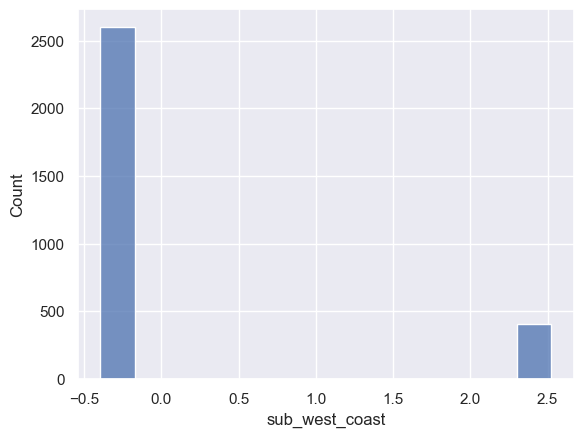

In [35]:
mean = after_drops["sub_west_coast"].mean()
std = after_drops["sub_west_coast"].std()
scaled = (after_drops["sub_west_coast"] - mean) / std

sns.histplot(scaled)

### 4. Model Development and Hyperparameter Tuning

#### XGBoost

In [180]:
# visualize correlations between features
# implement XGBoost
# make it deterministic and try different random states - my split is deterministic and maybe my preprocessing too? (still abstract it out)
# implement the pattern-submodel approach in a function and try different algorithms
# basic interpretation - which features are most important
# look into making a limited dataset with more recent data

In [185]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              # "missing": [np.nan], 
              #"max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

params = ParameterGrid(param_grid)
val_scores = np.zeros(len(params))
models = []
for i, param_combo in enumerate(params):
    print(param_combo)
    XGB = xgboost.XGBRegressor()
    XGB.set_params(**param_combo, early_stopping_rounds=50)
    XGB.fit(X_train_prep,y_train, eval_set=[(X_val_prep, y_val)], verbose=False)
    val_pred = XGB.predict(X_val_prep)
    rmse = mean_squared_error(y_val, val_pred, squared=False)
    val_scores[i] = rmse
    models.append(XGB)
    print(f"Model {i} val score: {rmse}")

print(f"\nBest params: {params[np.argmin(val_scores)]}")
best_model = models[np.argmin(val_scores)]
y_test_pred = best_model.predict(X_test_prep)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print('Test RMSE:', test_rmse)
print('Test R2:', r2_score(y_test,y_test_pred))

{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'n_estimators': 10000, 'reg_alpha': 0.0, 'seed': 0, 'subsample': 0.66}
Model 0 val score: 4.48647300911303
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'n_estimators': 10000, 'reg_alpha': 0.01, 'seed': 0, 'subsample': 0.66}
Model 1 val score: 4.534998301977709
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'n_estimators': 10000, 'reg_alpha': 0.1, 'seed': 0, 'subsample': 0.66}
Model 2 val score: 4.477935303513411
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'n_estimators': 10000, 'reg_alpha': 1.0, 'seed': 0, 'subsample': 0.66}
Model 3 val score: 4.513105881923087
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'n_estimators': 10000, 'reg_alpha': 10.0, 'seed': 0, 'subsample': 0.66}
Model 4 val score: 4.612627062515733
{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'n_estimators': 10000, 'reg_alpha': 100.0, 'seed': 0, 'subsample': 0.66}
Model 5 val score: 4.931562905429065

Best params: {'subsample': 0.66, 'seed': 0, 'reg_alpha